# <center> EVK Tools Usage
# <center> Prepared by Denver Lloyd
# <center> 10/27/2021

## Introduction

- The sever_app module requires `server_app_host` and `set_sensor` to be on the host machine and all other files to be on the receiver machine. A config is provided that sets the sensor state and requested frame count and exposure points. The flow is as follows:
1. Run `server_app_host.py` from the receiver machine using ssh which initiates setting the sensor and the capture. A config path on the host machine is provided `config_path_host` and the location of server_app_host to be on ran on the host machine via keyword `capture_script`.
    - Support is also included for creating a config on the receiver machine and providing the path to this local config via the keyword `config_path_rec`. If `config_path_rec` is provided then that config will be copied to the host and used for the capture.
     - `server_app_host.py` sets the sensor state using `set_sensor.py` using the config params, iterates over exposure points from the config, captures, and saves off the images to a user defined directory (no need to change this directory).
     - a csv is also created and saved on the host machine containing the sensor state information and the image path for each operating point.
2. Images and the state csv file for each image is transferred to the receiver machine using ssh and a user defined directory via the keyword `rpath`.
3. images are renamed if desired on the receiver pc and the csv state file is updated to reflect the new local path
4. directory on host machine is cleared once all images and the state file are transferred and ready for another capture 

In [14]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from ams_jetcis.evk_tools import server_app
import pdb
plt.rcParams['figure.figsize'] = (12, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Instance of Server_App

### params

In [18]:
# username of host machine
username = 'jetcis'

# password of host machine
password = 'jetcis'

# port of host machine for ssh
port=22

# hostname of host machine for ssh
hostname = '192.168.1.35'

# create host path
hpath = r'/home/jetcis/staged_images'

# receiver path
rpath=r'C:\data\MIRA050\Example'

# sensor to run
sensor_name = 'Mira050'

# script that captures images and sends to socket
capture_script = r'/home/jetcis/jetcis/software/trunk/sw/ams_jetcis/evk_tools/server_app_host.py'

# config on host machine
config_path_host = r'/home/jetcis/jetcis/software/trunk/sw/ams_jetcis/configs/Mira050.ini'

config_path_rec = None

## Config Examples (.ini)

### Single Exposure Point

[Mira050]

analog_gain=1

digital_gain=4

frame_count=20

bit_mode=12

exposure=10

### Multiple Exposure Points

[Mira050]

analog_gain=1

digital_gain=4

frame_count=20

bit_mode=12

exposure=[1, 10, 20, 50, 1000, 5000]

### Linear Sweep of Exposure Points

- config syntax for exposure: `start point:end point:number of steps`

[Mira050]

analog_gain=1

digital_gain=4

frame_count=20

bit_mode=12

exposure= 1:1000:100

## Case 1: Exposure Sweep

- In this case we do not need to know any information that is not available on the evk, so we simply sweep exposure.
    - an example of this would be a light source with a fixed irradiance

### Config

- Here I am setting `config_path_rec` to a local config on my machine which will be written to the host and used for the capture. Below are the example params

- I am sweeping exposure from 1 to 1000 in 10 steps
    - `np.linspace(1,1000,10)`

[Mira050]

exposure = 1:1000:10

analog_gain = 1

digital_gain = 2

frame_count = 20

bit_mode = 12

In [186]:
# create instance of Server_App
sa = server_app.Server_App(username=username,
                           password=password,
                           port=port,
                           hostname=hostname,
                           hpath=hpath,
                           rpath=r'C:\data\MIRA050\Example',
                           sensor_name=sensor_name,
                           capture_script=capture_script,
                           config_path_host=config_path_host,
                           config_path_rec=r'C:\workspace\evk_tools\source\Mira050_Example.ini')

Connected to paramiko (ssh)


In [187]:
# get the images
out = sa.get_images()


#transfer to receiver
sa.transfer()


# rename images
label = f'example_label'
sa.rename_stack(label)

# delete from host
sa.delete_images()

[b'']

Note: the above sequence can be achieved by calling `sa.main()`

### Directory After Running

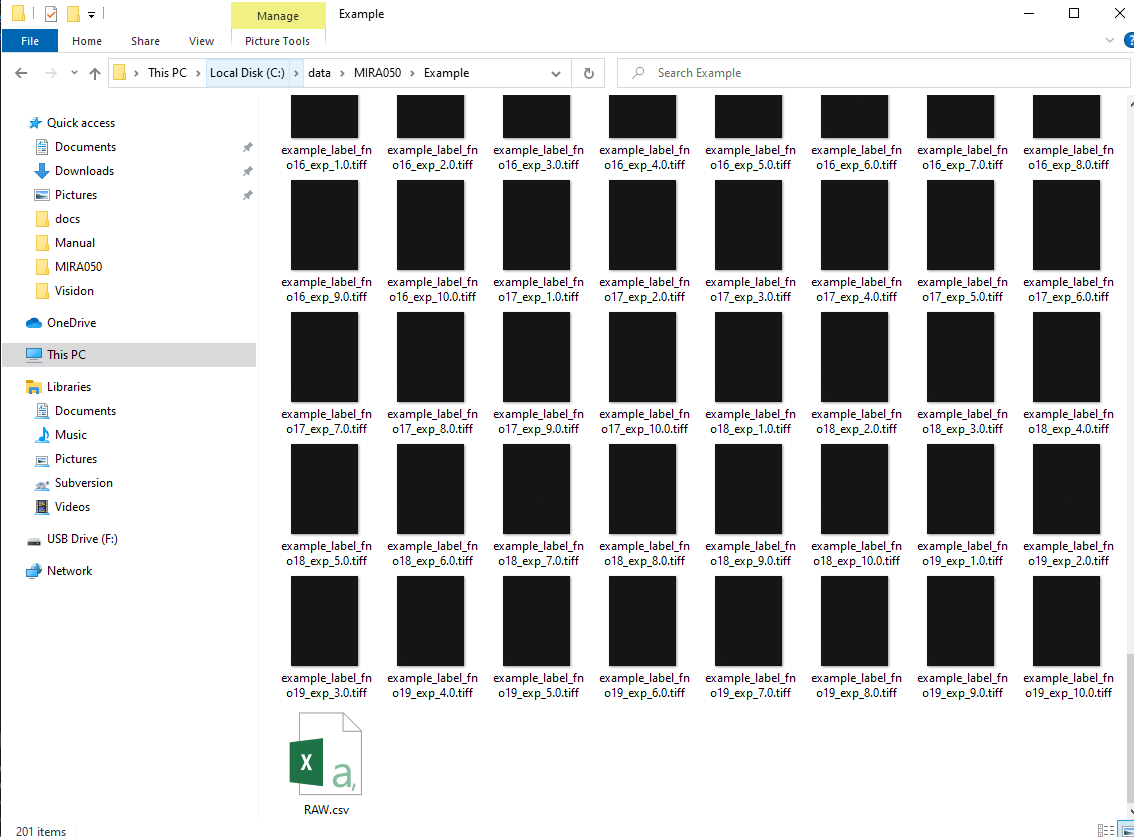

In [161]:
from IPython.display import Image
Image(filename='C:\data\evk_tools.png')

### Example of state csv in directory

In [162]:
raw = pd.read_csv(r'C:\data\MIRA050\Example\RAW.csv')

In [163]:
raw.head()

,analog_gain,bit_mode,digital_gain,exposure,frame_count,image_path
0,1,12bit,4,1.0,20,C:\data\MIRA050\Example\example_label_fno0_exp...
1,1,12bit,4,1.0,20,C:\data\MIRA050\Example\example_label_fno1_exp...
2,1,12bit,4,1.0,20,C:\data\MIRA050\Example\example_label_fno2_exp...
3,1,12bit,4,1.0,20,C:\data\MIRA050\Example\example_label_fno3_exp...
4,1,12bit,4,1.0,20,C:\data\MIRA050\Example\example_label_fno4_exp...


## Case 2: External Sweep

- In this case we are using an exteral system (like a light source) where we need to change the power after every capture.
    - here a loop is required

### Config

- Here I am setting `config_path_rec` to a local config on my machine which will be written to the host and used for the capture. Below are the example params

- I am using a fixed exposure and will loop through my 'light source values' and run the sequence over and over updating my image labels to reflect my params not captured by setting the sensor state

[Mira050]

exposure = 1000

analog_gain = 1

digital_gain = 2

frame_count = 20

bit_mode = 12

In [173]:
# create instance of Server_App
sa = server_app.Server_App(username=username,
                           password=password,
                           port=port,
                           hostname=hostname,
                           hpath=hpath,
                           rpath=r'C:\data\MIRA050\Example',
                           sensor_name=sensor_name,
                           capture_script=capture_script,
                           config_path_host=config_path_host,
                           config_path_rec=r'C:\workspace\evk_tools\source\Mira050_Example2.ini')

Connected to paramiko (ssh)


In [175]:
raw_update = pd.DataFrame()

# transfer the config
sa.transfer_config()

# connect to fake light source

# define power sweep
power = np.linspace(0,10,10)

# iterate over power
for pp in power:
    
    # set the light source
    power_ = round(pp, 1)
    
    # capture images
    out = sa.get_images()
    
    # transfer images
    sa.transfer()
    
    # update the label
    label = f'power_{power_}'
    sa.rename_stack(label)
    
    # open raw file and add external instrument specific labels
    raw = pd.read_csv(os.path.join(sa.rpath, 'RAW.csv'))
    raw['Power'] = power_
    
    # concat to master frame each loop (will be saved after sweep is complete)
    raw_update = pd.concat([raw_update, raw]).reset_index(drop=True)
    
    # delete the images from host
    sa.delete_images()

raw_update.to_csv(os.path.join(sa.rpath, 'RAW.csv'), index=False)

### Directory After Running

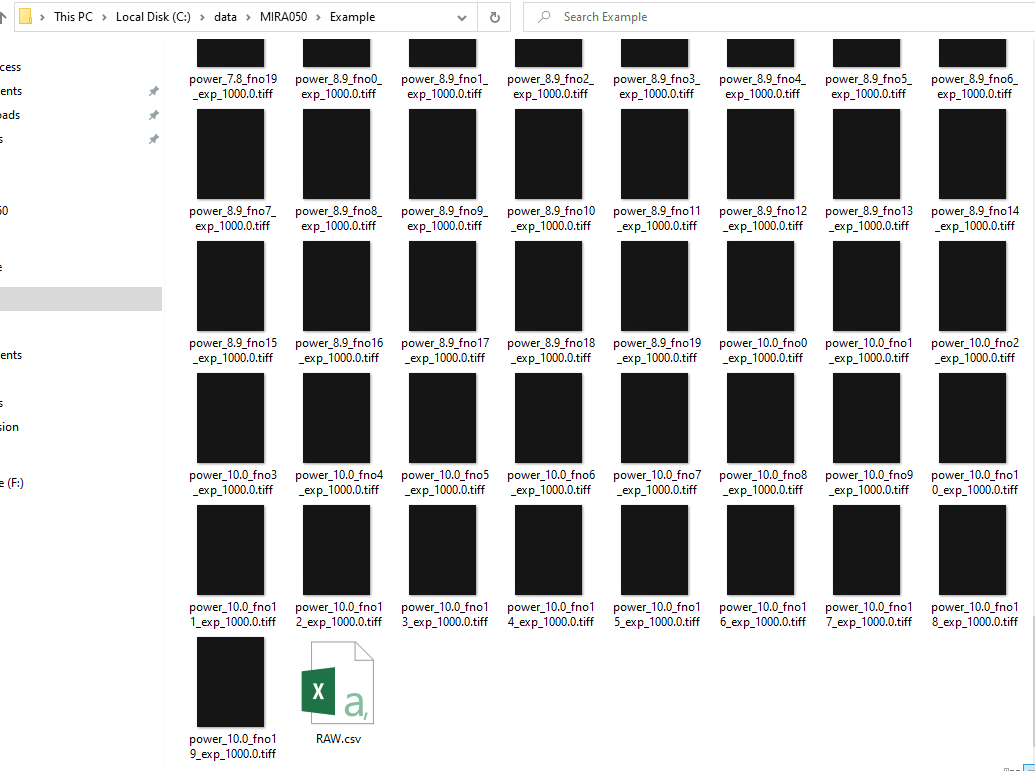

In [176]:
from IPython.display import Image
Image(filename='C:\data\evk_tools2.png')

### Example of state csv in directory

In [177]:
raw = pd.read_csv(r'C:\data\MIRA050\Example\RAW.csv')

In [178]:
raw.head()

,analog_gain,bit_mode,digital_gain,exposure,frame_count,image_path,Power
0,1,12bit,2,1000.0,20,C:\data\MIRA050\Example\power_0.0_fno0_exp_100...,0.0
1,1,12bit,2,1000.0,20,C:\data\MIRA050\Example\power_0.0_fno1_exp_100...,0.0
2,1,12bit,2,1000.0,20,C:\data\MIRA050\Example\power_0.0_fno2_exp_100...,0.0
3,1,12bit,2,1000.0,20,C:\data\MIRA050\Example\power_0.0_fno3_exp_100...,0.0
4,1,12bit,2,1000.0,20,C:\data\MIRA050\Example\power_0.0_fno4_exp_100...,0.0
